In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
import pandas as pd
import numpy as np
import gensim
from textblob import TextBlob
import json
import re
import itertools
import csv
import re
import nltk
from nltk.stem import WordNetLemmatizer

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
import keras.utils
from keras import utils as np_utils

Using TensorFlow backend.


In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Activation, GlobalAveragePooling1D, Flatten, Concatenate, Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
from keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

import fnmatch

import warnings

import string
from pathlib import Path
from random import shuffle
from ast import literal_eval

warnings.filterwarnings('ignore')

In [0]:
WINDOWS_SIZE = 100
labels=['predator','non-predator']
num_classes = len(labels)

## Loading the xml converted csv file

In [0]:
pan_data = pd.read_csv(r'/content/drive/My Drive/pan.csv',encoding='latin1')
pan_data.sample(10)

,id,line,author,time,text
26685,0c505c796b9688c77f9666f82c4d3419,2,a85b5641fcc96b5f23be0dbde9681957,21:13,asl
464926,9423d47d1645d76e1521095a04fdc7bd,5,828997d3329f6368569d69d0d2baa3e6,11:05,"type ctrl-r, &quot; at the search prompt"
264787,519ff2164ba06effda4e44c1b27fd1c1,23,6e52db3e4ee1db0c1691ae6bcdc7ea1d,10:09,cause i am
477957,f5c45c9a6aad3c90b2899200142d5b51,27,98b94e5cd9b265939c3c40c3f86acd80,15:19,i would personally just do: iptables -A INPUT...
448016,560c4c0733b8d84472b1349dd9ec99e7,34,52007f5916ff1b5ae0d4a4c5a72e6a0f,06:33,he lives with me just me and him
314486,e492e3df95ad68bc1840490ee02841ce,3,b8810fee2f4a71f849f3f7409546d1d9,13:08,f4dfad803df83144a5be86d9bca87678: I can take a...
627745,5a0c2be0d405d89cea498886e2ae8325,13,4fdcd110ffb90955e2fd546396d339a0,16:13,Location?
59234,8dfb481419613074b35c23184ba8deab,16,97a7ab2992aef4fef68d7ce729a48be5,16:51,im f
673247,432d36d538259e125e4540a11802e1b2,7,0c1cea012c66392e027d8f40f3d71a51,04:40,?
833489,c4f976da89385fcf3f303b2aed11a0f1,18,e0ec7e5d4a0224c7f2447d8fd4786c20,05:50,i eagerly lick your dripping twat and i then s...


In [0]:
pan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903607 entries, 0 to 903606
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      903607 non-null  object
 1   line    903607 non-null  int64 
 2   author  903607 non-null  object
 3   time    903607 non-null  object
 4   text    900629 non-null  object
dtypes: int64(1), object(4)
memory usage: 34.5+ MB


In [0]:
pan_data['text'].replace('', np.nan, inplace=True)
pan_data.dropna(subset = ["text"], inplace=True)
pan_data.reset_index(drop=True, inplace=True)
len(pan_data)

900629

In [0]:
pan_data['word_count'] = pan_data['text'].apply(lambda x: len(str(x).split(" ")))
pan_data[['text','word_count']].head()

,text,word_count
0,Hola.,1
1,hi.,1
2,whats up?,2
3,not a ton.,3
4,you?,1


In [0]:
pan_data['char_count'] = pan_data['text'].str.len() ## this also includes spaces
pan_data[['text','char_count']].head()

,text,char_count
0,Hola.,5
1,hi.,3
2,whats up?,9
3,not a ton.,10
4,you?,4


In [0]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

pan_data['stopwords'] = pan_data['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
pan_data[['text','stopwords']].head()

,text,stopwords
0,Hola.,0
1,hi.,0
2,whats up?,0
3,not a ton.,2
4,you?,0


## Removing Punctuation

In [0]:
pan_data['text'] = pan_data['text'].str.replace('[^\w\s]','')
pan_data['text'].head()

0         Hola
1           hi
2     whats up
3    not a ton
4          you
Name: text, dtype: object

### Removing the words that occured less than 10 times

In [0]:
freq = pd.Series(' '.join(pan_data['text']).split()).value_counts()[-500:]
freq

warrantee                      1
traverses                      1
Woww                           1
icab                           1
authentation                   1
                              ..
aposaposapos__aposapos         1
myLayoutgtaddWidgetwhatever    1
6296435                        1
coursedo                       1
defeintiely                    1
Length: 500, dtype: int64

In [0]:
freq = list(freq.index)
pan_data['text_clean'] = pan_data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
pan_data['text_clean'].head()

0         Hola
1           hi
2     whats up
3    not a ton
4          you
Name: text_clean, dtype: object

## Changing slang text

In [0]:
#pan_data['text_clean']= pan_data['text_clean'].apply(lambda x: str(TextBlob(x).correct()))

In [0]:
misspell_dict = {"aren't": "are not", "can't": "cannot", "couldn't": "could not","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hasn't": "has not","haven't": "have not", "he'd": "he would","he'll": "he will","he's": "he is",
"i'd": "I had", "i'll": "I will","i'm": "I am", "isn't": "is not","it's": "it is", "it'll": "it will","i've": "I have","let's": "let us","mightn't": "might not", "mustn't": "must not", "shan't": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is",
"shouldn't": "should not", "that's": "that is", "there's": "there is","they'd": "they would", "they'll": "they will", "they're": "they are","they've": "they have","we'd": "we would", "we're": "we are","weren't": "were not", "we've": "we have", "what'll": "what will",
"what're": "what are","what's": "what is","what've": "what have","where's": "where is", "who'd": "who would", "who'll": "who will","who're": "who are", "who's": "who is", "who've": "who have","wont":"will not", "won't": "will not","wouldn't": "would not", "you'd": "you would",
"you'll": "you will","you're": "you are",  "you've": "you have", "wasn't": "was not", "we'll": "we will", "tryin'":"trying", "whatcha":"what are you","luv":"love","sux":"sucks","y'all":"you all", "ain't":"is not","amn't":"am not","aren't":"are not","can't":"cannot", "ain't":"is not",
"amn't":"am not","'cause":"because","couldn't've":"could not have","could've":"could have","daren't":"dare not","daresn't":"dare not", "dasn't":"dare not","didn't":"did not","doesn't":"does not","don't":"do not","e'er":"ever","em":"them","kinda":"kind of","needn't":"need not","ne'er":"never",
"o'":"of","o'er":"over","ol'":"old","everyone's":"everyone is","finna":"fixing to","gimme":"give me","gonna":"going to","gon't":"go not","gotta":"got to","I'm'a":"I am about to","I'm'o":"I am going to","isn't":"is not","it'd":"it would","it'll":"it will","it's":"it is","I've":"I have",
"there'll":"there will","there're":"there are","these're":"these are","they'd":"they would","they'll":"they will","they're":"they are","they've":"they have","this's":"this is","those're":"those are","'tis":"it is","'twas":"it was","wanna":"want to"}

def _get_misspell(misspell_dict):
    misspell_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))
    return misspell_dict, misspell_re


def replace_typical_misspell(text):
    misspellings, misspellings_re = _get_misspell(misspell_dict)

    def replace(match):
        return misspellings[match.group(0)]

    return misspellings_re.sub(replace, str(text))

In [0]:
pan_data['text_clean'] = pan_data['text_clean'].apply(lambda x : str(x).lower())
pan_data['text_clean'] = pan_data['text_clean'].apply(replace_typical_misspell)

In [0]:
pan_data

,id,line,author,time,text,word_count,char_count,stopwords,text_clean
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,Hola,1,5,0,hola
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fc4d493f243d4caa49747,03:20,hi,1,3,0,hi
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fc4d493f243d4caa49747,03:20,whats up,2,9,0,whats up
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton,3,10,2,not a ton
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you,1,4,0,you
...,...,...,...,...,...,...,...,...,...
900624,4ed6b02ae537fdfd6078597b706292a8,101,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,oh ok,2,5,0,oh ok
900625,4ed6b02ae537fdfd6078597b706292a8,102,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,i will look for you tomorrow,6,28,4,i will look for you tomorrow
900626,4ed6b02ae537fdfd6078597b706292a8,103,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,ok,1,2,0,ok
900627,4ed6b02ae537fdfd6078597b706292a8,104,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,bye lissa,2,9,0,bye lissa


In [0]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&quote)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
pan_data['text_clean'] = preprocess(pan_data['text_clean'])

In [0]:
pan_data.sample(10)

,id,line,author,time,text,word_count,char_count,stopwords,text_clean
293225,5d4469c8c89c17fae2c17d2352c140be,15,5f6edfe03efa62a63eebfb6f0d232020,22:37,iam located in the state of Maryland,7,36,3,iam located in the state of maryland
134817,eed6662a0039b6e8b16f58fe0969bcf7,4,d73b8031eacc1f22118865c048887b57,01:23,nope,1,4,0,nope
608608,ceb4ca07f0db086c9f40d434449609d7,42,9163a1ff41bead24cf2628c6baf88d01,19:03,too many perverts,3,17,1,too many perverts
572600,9918e5350906b5e82dc659a2a2b1ec3e,4,ee595f173473917f5cf2d4b6445c13e9,14:27,yer,1,3,0,yer
413411,9c74c64e76140e80f3d3ca37930161f9,15,ee4be2c1b14970c16e9b49c004c5335e,13:23,so do u want it,5,15,3,so do u want it
260400,1a4d5cd8add6408cfc4d1b1d1208ffd0,83,58869a2e5c3f0eab9aa398b0a798e354,15:34,httppastieorg965384,1,24,0,httppastieorg965384
695226,cc4e0197c0a37a0faad92c57c835b695,46,d08bbf205cc14c09d4e567440368da8f,00:10,Do u masterbate,3,15,0,do u masterbate
493607,5b06cb1154d8b1880b04fd9d03cb7041,38,4253ca4b169d14524f96264e68de4ee2,04:59,thts neat,2,9,0,thts neat
445826,b15b9d544c2361331c3d3d8db1aeb18c,19,52d8d282d4fa3d9698847619778cb628,06:54,asl,1,3,0,asl
557451,f455a611bc0c2e1f66d2fb180ff8b901,4,ea2202a9f28c42632526bbc3da5cf063,16:20,asl,1,5,0,asl


In [0]:
pan_data['text_clean'].replace('', np.nan, inplace=True)
pan_data.dropna(subset = ["text_clean"], inplace=True)
pan_data.reset_index(drop=True, inplace=True)
len(pan_data)

880156

### Removing hastags

In [0]:
def deepclean(text):
  new_string1 = re.sub('[a-zA-Z][0-9]{30,}','', text) # Remove the words longer than 30 characters
  new_string2 = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+] |[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', new_string1) # remove URLs 
  new_string3 = new_string2.encode('ascii', 'ignore').decode('ascii') # removes all non-ascii characters
  #new_string4 = ''.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", new_string3).split())
  new_string5 = new_string3.lower()

  return new_string5
  

In [0]:
pan_data['text_clean'] = pan_data.apply(lambda row: deepclean(row.text_clean), axis=1)

In [0]:
pan_data.sample(10)

,id,line,author,time,text,word_count,char_count,stopwords,text_clean
329482,508a3eb5831b0714543b6e64009e202f,52,5871a60fe02da4a52382ac454e3a1420,04:35,Itaposs right under her butt hole,7,38,2,itaposs right under her butt hole
405439,393d66dbc5a5b38e1c9f81577374c3d9,240,1e796ded59a56f729ecdf625e9007b7f,17:07,if u want to,4,12,2,if u want to
466321,cd5ca86984eef71fd291a766d50606c5,51,edb259c0e0038f38bb200bc20c8cbf7e,13:12,can arise,2,9,1,can arise
793411,9230b77091849682f5e099804051ec1d,12,94d50e2efa8ecc99acd742d7cdd18f4a,22:53,thats souseful,3,18,0,thats souseful
171173,729220291935e4cd9124fbfcd40b4ff5,111,961fc4821bc79eeb9991d658b181ae35,19:22,awwww,1,5,0,awwww
868233,a23b325461d108fa884c008c1480c9d7,60,14af4ca97e316b17ea96286dc6882fd4,21:46,I dont need this to be extensible so namespace...,13,72,6,i dont need this to be extensible so namespace...
3276,993e5d8871aa632237525e3c8fc245b7,2,83f45a26da9ec906b48f11b6ad30e45b,07:17,hi,1,2,0,hi
799522,c82b0b81c2e2c9f5e018ea665f265a30,1,02c7872d64996b921664199a53af8226,07:49,SgtJohnson try azureussupport,3,32,0,sgtjohnson try azureussupport
679710,80812a60e39ad1b9cbe64252b26d865b,67,8d56165e9ca5f4e76e9f121d6036bbe4,17:08,lol,1,3,0,lol
17265,61f6c3151bd60f5a39d0665062a1c185,4,1203e5a97b4c369293d03d87f7f8a1f5,16:54,a lot,2,5,1,a lot


# Remove all emojis from the chats

In [0]:
def remove_emoji(string):
    emoji_pattern = re.compile('(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)')
    return emoji_pattern.sub(r'', string)

In [0]:
pan_data['text_clean'] = pan_data.apply(lambda row: remove_emoji(row.text_clean), axis=1)

In [0]:
pan_data.sample(20)

,id,line,author,time,text,word_count,char_count,stopwords,text_clean
4479,5ef3fc28bea157bd5dadd4948c369827,90,ddd83f159f3e5bb134e175cad935c1db,10:00,comes with age,3,14,1,comes with age
86246,841a2e05ac7cd2c2bd7a426d66bf27b4,42,69b0d3dfe919a6b860a9fac82de52a7e,02:46,and for such stupid reasons,5,27,3,and for such stupid reasons
212089,fb4d3d767cfd719ed5931c6537edc24a,27,a091c77c2d3dd805b1773a40307d3983,02:41,lol happy belated birthday,4,26,0,lol happy belated birthday
690548,7ffeb6417b7c7910c9f7b35052ee1742,108,2909df86d8d914f61dea394637cf2022,12:23,is more for desktop stuff,5,26,3,is more for desktop stuff
643912,e656d3ab2cf72f13eeef00fe5497c044,7,9ac74f6a123c0fbba9e0b8b784a5fed2,13:19,but,1,3,1,but
20586,f80b975a230dfa4fa40c200a25e432e5,78,b8810fee2f4a71f849f3f7409546d1d9,13:55,66b0d785bfa15d051888c24dabba7342 I dont know,4,46,1,66b0d785bfa15d051888c24dabba7342 i dont know
163980,228b953e534c5d9af19d1100e867c7de,20,523fe198be0f9f75865ad7fcf385916a,15:37,have facebook,2,14,1,have facebook
61820,6474a75ade9eff0ce82fd77a91eff9ca,79,03957f443c7790f9642db14bbc59df11,19:36,Well I will need to go to bed soon so I will b...,17,74,7,well i will need to go to bed soon so i will b...
639037,e05656851757be4170266d1632e3a414,4,3cd3071a43b643dd17adeb2262c3a29d,20:26,yess,1,4,0,yess
92406,285d4fc04eeffeb25cb722eb15a92549,136,76680563b02870d015080e95984df8fc,16:32,Its IRC bot I try to avoid very long descriptions,10,52,2,its irc bot i try to avoid very long descriptions


## Changing the SMS Slang to english words

In [0]:
from IPython.display import display
slang_dict= {"afaik":"as far as i Know","afk": "away from keyboard","asap":"as soon as possible","atk":"At The Keyboard","atm":"at the moment","a3":"anytime, anywhere, anyplace","bak":"back at keyboard","bbl":"be back later","bbs":"be back soon",
"bfn":"bye for now","b4n":"bye for now","brb":"be right back","brt":"be right there","btw":"by the way","b4":"before","b4n":"bye for now","faq":"frequently asked questions","fc":"fingers crossed",
"fwiw":"for what it's worth","fyi":"for your information","gal":"get a life","gg":"good game","gn":"good night","gmta":"great minds think alike","gr8":"great","ily":"i love you","imho":"in my honest opinion",
"imo":"in my opinion","iow":"in other words","ldr":"long distance relationship","lmao":"laugh my a** off","lol":"laughing out loud","ltns":"long time no see","l8r":"later","mte":"my thoughts exactly","m8":"mate","nrn":"no reply necessary",
"oic":"oh i see","pita":"pain in the a**","prt":"party","prw":"parents are watching","rofl":"rolling on the floor laughing","roflol":"rolling on the floor laughing out loud","roflmao":"rolling on the floor laughing my a** off","stats":"your sex and age",
"asl":"age, sex, location","thx":"thank you","ttfn":"ta-ta for now","ttyl":"talk to you later","wb":"welcome back","wtf":"what the f***","wth":"what the hell","wtg":"way to go","wuf":"where are you from?",
"w8":"wait","2g2bt":"too good to be true","2moro":"tomorrow","2nite":"tonight","abt":"about","coz":"because","cos":"because","bcoz":"because","bf":"boyfriend","gf":"girlfriend","bff":"best friend forever", "btw":"by the way", "cm":"call me","csl":"can't stop laughing",
"dm":"direct message","dnbl8":"don't be late","g4i":"go for it","gnoc":"get naked on camera","gab":"getting a beer","gas":"got a second?","icymi":"in case you missed it","j2lyk":"just to let you know","lmk":"let me know", "msg":"message","plz":"please",
"ur":"your","iwsn":"i want sex now","nifoc":"naked in front of computer","pir":"parent in room","cu46":"see you for sex","thot":"that hoe over there","cid":"acid (the drug)","broken":"hungover from alcohol","pos":"parent over shoulder","sugarpic":"suggestive or erotic photo",
"kotl":"kiss on the lips","lmirl":"let us meet in real life","pron":"porn","tdtm":"talk dirty to me","ipn":"im posting naked","lhs":"lets have sex","wttp":"want to trade pictures?","doc":"drug of choice","twd":"texting while driving","gypo":"get your pants off","kpc":"keeping parents clueless"}

def process_data(data):
    data['text_clean']=data['text_clean'].str.lower()
    data['text_clean']=data['text_clean'].astype(str)
    data.replace(slang_dict,regex=True,inplace=True)
    display(data.head(2))
    return data

In [0]:
pan_data= process_data(pan_data)

,id,line,author,time,text,word_count,char_count,stopwords,text_clean
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,Hola,1,5,0,hola
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fingers crossed4d493f243d4caa49747,03:20,hi,1,3,0,hi


In [0]:
pan_data.sample(10)

,id,line,author,time,text,word_count,char_count,stopwords,text_clean
80085,d1bce5997ccdad64516a16149d1boyfemaleriendinger...,3,femalea59933c7dce08ba7d4a9401e6b73803,12:44,what,1,5,0,what
408905,1b0female773e842afemaleb847e246boyfemaleriend0...,10,"9a5e2c7female72banytime, anywhere, anyplace2fe...",06:26,yeah pretty maleyouch welcomalee backyou,4,23,0,yeah pretty maleyouch welcomalee backyou
257557,b30efemaleingers crossedefemale66e03b3731d846d...,106,2a751a42619e8a40boyfemaleriend5115cb62135a69,01:36,not tomaleorrow,2,12,1,not tomaleorrow
581264,"5afemale5female84adfemale2dc141femaleanytime, ...",19,99ca41femaleee4femaled783female3female93decd8e...,00:12,thankss,1,7,0,thankss
874419,"63female2female3284anytime, anywhere, anyplace...",1,d090448efemaleingers crossed59female5female5b3...,01:56,hi,1,2,0,hi
177831,615832e2d7edceb6068713female1560a8992,37,a068d03612a6a4dfemale8556db3786dboyfemaleriend...,21:14,links and styoufemalefemale heh,4,19,1,links and styoufemalefemale heh
205332,"213ee6eb0ca99cda28a9a6b363femaleb3anytime, any...",16,8319female27d70ed91d8a5cboyfemaleriend30670cc859e,06:52,Cyoyour,1,4,0,see yoyoyour
382106,33c55c79da42cad51e124124e92d8cd4,4,61a753181ceb0457c24add0908da4e2e,23:40,SAY HI,2,7,0,say hi
457319,b7718female8b17094female2019female32aa79a8c5e29,23,6ca6female5b604595717cacc5bboyfemalerienda0aa8ec6,09:14,giv yoyour pi see,3,10,0,giv yoyour pi see
198750,cb31afemale9e1446360a155efemale8c4570bb786,3,49femalefemaledd02aa55female3638075c36c3ce5d6f...,20:48,Donaparent over shoyouldert tell malee yoyou a...,7,34,4,donaparent over shoyouldert tell malee yoyou a...


In [0]:
def text_to_wordlist(text, remove_stopwords=True, stem_words=False):    
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()
    wordnet_lemmatizer = WordNetLemmatizer() 
    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [wordnet_lemmatizer.lemmatize(w) for w in text if not w in stops ]
        text = [w for w in text if w != "nan" ]
    else:
        text = [wordnet_lemmatizer.lemmatize(w) for w in text]
        text = [w for w in text if w != "nan" ]
    
    text = " ".join(text)

    # Clean the text 
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    text = re.sub(r"\<", " ", text)
    text = re.sub(r"\>", " ", text)
    
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [0]:

pan= pan_data.copy() # However, if you need the original list unchanged when the new list is modified, you can use copy() method. This is called shallow copy.
pan['text_clean'] = pan.apply(lambda row: text_to_wordlist(row.text_clean).split(), axis=1)

In [0]:
pan.sample(10)

,id,line,author,time,text,word_count,char_count,stopwords,text_clean
88752,1f2470036098fingers crossed675e7c0c6d9663b82e,20,fboyfriende6e979bc4793e104d07b787ce2909,14:05,yep,1,6,0,[yep]
711503,bb57959d8db7630e1dff0b5e812e7e51,99,0194boyfriendef36fingers crossed3ad600f7beb9ee...,15:22,yeah,1,4,0,[yeah]
444256,56bc387c42fb0619ac19fd0ecec7247f,5,f4a1e999136862eb2efd830cf72310c0,03:44,kbye,1,4,0,[kbye]
13689,e07c3e4e0e7b3900b174490fa4e22beforec,9,7ef291c89ad915978b203d427919cfbb,08:32,does varrun exist,5,22,1,"[varrun, exist]"
828640,eff52b7c7b28d318c0fd6dd6fdec463b,53,b2d09b73eb5ad0228f9cb2e51485a45f,12:04,its line 5464 in jsobjcpp,5,27,2,"[line, 5464, jsobjcpp]"
393505,981747f9b19120fb65616d36c7272a6e,6,8ab83fdb908beforee70a8e133e649134c55,00:53,18 f,2,4,0,"[18, f]"
689297,c96a8e0c55cf58c12aa860fe9c573cdd,52,c6e059a13146edfingers crossed52cda747537db27f,00:42,are you fat,3,12,2,[fat]
309366,95539910a8fe6035ecdded42181c5ab3,19,0526eb9cfingers crossedee11c0036f3fa6d11158d5,21:01,that why i on here to enjoy and have pleasyoure,10,45,8,"[enjoy, pleasyoure]"
56902,a7a2444ac3d45b7fb68e4eb1c224a401,34,1fe903a9754c793942f3a7f1bad0bb50,08:15,yep,1,3,0,[yep]
519322,e67f3cc008cbddc57ae77ec3f9b108b2,2,6boyfriend6443c8d8d3dbd2e8798cefingers crossed...,09:27,httptwittercomyk_Michelle maiko0905 HCARDÈÅøÔºü,3,58,0,"[httptwittercomyk, michelle, maiko0905, hcard]"


In [0]:
pan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880156 entries, 0 to 880155
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          880156 non-null  object
 1   line        880156 non-null  int64 
 2   author      880156 non-null  object
 3   time        880156 non-null  object
 4   text        880156 non-null  object
 5   word_count  880156 non-null  int64 
 6   char_count  880156 non-null  int64 
 7   stopwords   880156 non-null  int64 
 8   text_clean  880156 non-null  object
dtypes: int64(4), object(5)
memory usage: 60.4+ MB


In [0]:
words = [w for w in pan['text_clean'].tolist()]
words = set(itertools.chain(*words)) #chain('ABC', 'DEF') --> A B C D E F
vocab_size = len(words)

In [0]:
pan['text_clean']=[" ".join(x) for x in pan['text_clean'].values]

## Unigram of top 20 words used

hi 40720
like 26932
im 26396
sex 23706
age 23108
hey 21482
location 21128
yoyour 18698
want 18393
dont 18289
ok 16803
know 16007
laughing 15441
loud 15012
think 12866
yeah 12532
use 12515
good 12475
shoulder 11776
yes 11666
work 11142
thats 10876
oh 10762
make 10106
need 9660
say 9484
way 9339
really 9005
iaparent 8887
time 8694
got 8569
right 8555
bug 8421
thing 7687
hello 7653
ththem 7652
going 7329
shoulderm 7198
mean 7007
drug 6961


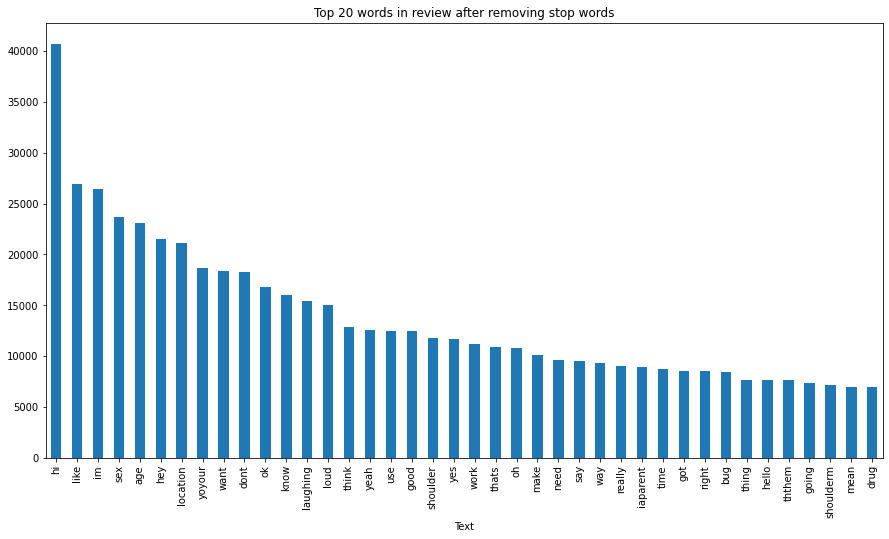

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
#The distribution of top unigrams

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(pan['text_clean'].dropna(), 40)

for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review after removing stop words',figsize=(15,8))

## Bigram of top 20 words used

age sex 20977
sex location 20707
laughing loud 14653
iaparent shoulderm 7046
loudolaughing loudolaughing 2999
dont know 2846
donaparent shouldert 2565
bugmail bug 2527
shoulder aparent 2455
pudi pudi 2342
random stranger 2152
chatting random 2115
shoulderre chatting 2113
stranger say 2100
itaparent shoulder 2085
look like 2068
youaparent shoulderre 1967
parent shouldersible 1956
dont think 1576
aparent shoulder 1552
say hi 1496
im syoure 1495
drug choiceument 1480
dont want 1466
loudolaughing loudlaughing 1458
loudoolaughing loudolaughing 1454
soul ginger 1419
ginger soul 1414
whataparent shoulder 1397
shoulderaparent shoulder 1364
aparent shoulderaparent 1322
shoulderaparent shoulderaparent 1310
im going 1306
ask question 1240
2533048022 2533048022 1173
represent omegle 1160
message omegle 1155
thataparent shoulder 1149
shoulder stranger 1148
omegle sent 1143


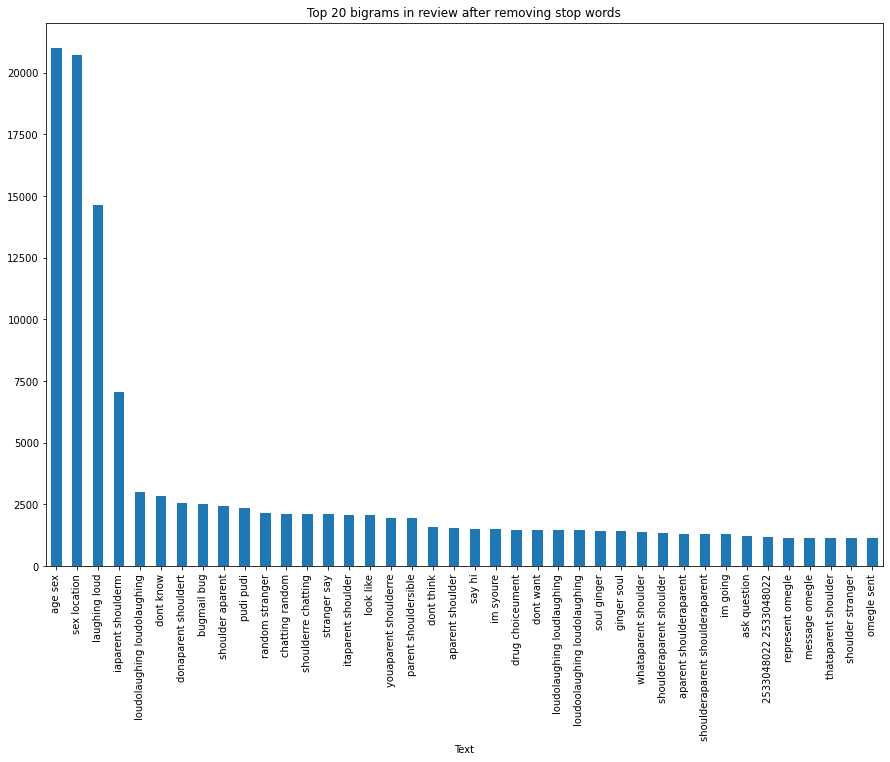

In [0]:
# The distribution of top bigrams

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(pan['text_clean'].dropna(), 40)

for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
df4.groupby('Text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 bigrams in review after removing stop words',figsize = (15,10))

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(pan['text_clean'])
train_bow

<880156x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 1919222 stored elements in Compressed Sparse Row format>

## Sentiment Analysis

In [0]:
pan['text_clean'][:5].apply(lambda x: TextBlob(x).sentiment)

0    (0.0, 0.0)
1    (0.0, 0.0)
2    (0.0, 0.0)
3    (0.0, 0.0)
4    (0.0, 0.0)
Name: text_clean, dtype: object

In [0]:
pan['sentiment'] = pan['text_clean'].apply(lambda x: TextBlob(x).sentiment[0] )
pan[['text_clean','sentiment']].head()

,text_clean,sentiment
0,hola,0.0
1,hi,0.0
2,whats,0.0
3,ton,0.0
4,,0.0


In [0]:
windows_size = 100
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(pan['text_clean']) # fit_on_texts creates the vocabulary index based on word frequency.
#The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word 

tokenizer.fit_on_sequences(pan['text_clean']) #texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.

pan['t_text_clean'] = tokenizer.texts_to_sequences(pan['text_clean'])
pan.head(15)

,id,line,author,time,text,word_count,char_count,stopwords,text_clean,sentiment,t_text_clean
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,Hola,1,5,0,hola,0.000,[1535]
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fingers crossed4d493f243d4caa49747,03:20,hi,1,3,0,hi,0.000,[2]
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fingers crossed4d493f243d4caa49747,03:20,whats up,2,9,0,whats,0.000,[75]
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton,3,10,2,ton,0.000,[2176]
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you,1,4,0,,0.000,[]
5,e621da5de598c9321a1d505ea95e6a2d,6,0158d0d6781fingers crossed4d493f243d4caa49747,03:20,same being lazy M or f,8,27,2,lazy f,-0.250,"[1793, 30]"
6,e621da5de598c9321a1d505ea95e6a2d,7,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,F,1,2,0,f,0.000,[30]
7,e621da5de598c9321a1d505ea95e6a2d,8,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:21,Ditto Iaparent over shoulderve done absolutely...,13,84,3,ditto iaparent shoulderve done absolutely noth...,0.200,"[8327, 37, 627, 225, 2162, 204, 147, 1650, 113..."
8,e621da5de598c9321a1d505ea95e6a2d,9,0158d0d6781fingers crossed4d493f243d4caa49747,03:21,M here Just got home from weekend trip Tired,11,49,1,got home weekend trip tired,-0.400,"[39, 302, 1088, 2656, 1114]"
9,e621da5de598c9321a1d505ea95e6a2d,10,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:21,Oh cool Fami love you thing,4,23,0,oh cool fami love thing,0.425,"[29, 53, 1352, 73, 43]"


### Padding the sequences to a window length of 100 ( due to the variable size of sentences)

In [0]:
pan["t_text_clean"] = pad_sequences(pan["t_text_clean"], value=0, padding="post", maxlen=windows_size).tolist()
pan.drop(pan[pan["t_text_clean"].map(len) > 100].index, inplace = True)

In [0]:
pan

,id,line,author,time,text,word_count,char_count,stopwords,text_clean,sentiment,t_text_clean
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,Hola,1,5,0,hola,0.0,"[1535, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fingers crossed4d493f243d4caa49747,03:20,hi,1,3,0,hi,0.0,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fingers crossed4d493f243d4caa49747,03:20,whats up,2,9,0,whats,0.0,"[75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton,3,10,2,ton,0.0,"[2176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you,1,4,0,,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
880151,4ed6b02ae537fdfd6078597b706292a8,101,74boyfriendingers crossed043bd5ce9c17b37ffae6e...,22:36,oh ok,2,5,0,oh ok,0.5,"[29, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
880152,4ed6b02ae537fdfd6078597b706292a8,102,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,i will look for you tomorrow,6,28,4,look tomorrow,0.0,"[59, 530, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
880153,4ed6b02ae537fdfd6078597b706292a8,103,74boyfriendingers crossed043bd5ce9c17b37ffae6e...,22:36,ok,1,2,0,ok,0.5,"[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
880154,4ed6b02ae537fdfd6078597b706292a8,104,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,bye lissa,2,9,0,bye lissa,0.0,"[259, 26054, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [0]:
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()



In [0]:
def fill_embedding_matrix(tokenizer):
    vocab_size = len(tokenizer.word_index) # tokenizer.word_index is the list that consist of all the unique words
    embedding_matrix = np.zeros((vocab_size+1, 100)) # creating an embedding matrix
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:        
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [0]:
embedding_matrix_lp = fill_embedding_matrix(tokenizer)
embedding_matrix_lp.shape

(209133, 100)

In [0]:
train_a =np.stack(pan['t_text_clean'])
train_y =np.stack(pan['sentiment'])

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [0]:
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)

In [0]:
bt = BatchNormalization()(answer_emb1)
lstm = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(bt)

dense1 = Dense(units=256, activation="relu")(lstm)
dense2 = Dense(units=256, activation="relu")(dense1)

flatten = Flatten()(dense2)

out = Dense(1,  activation='softmax')(flatten)

model = Model(inputs=[answer_inp], outputs=[out])
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          21018300  
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100)          400       
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100, 256)          25856     
_____________________________________________

In [0]:
model_glove_lstm_hist = model.fit(train_a, train_y, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, callbacks=[early_stopping])

Train on 585728 samples, validate on 251027 samples
Epoch 1/5
585728/585728 [==============================] - 143s 244us/step - loss: 15.3946 - acc: 0.0031 - val_loss: 15.4072 - val_acc: 0.0029
Epoch 2/5
585728/585728 [==============================] - 142s 243us/step - loss: 15.3946 - acc: 0.0031 - val_loss: 15.4072 - val_acc: 0.0029
Epoch 3/5
146000/585728 [======>.......................] - ETA: 1:31 - loss: 15.3827 - acc: 0.0030

KeyboardInterrupt: ignored

In [0]:
def plot_acc(history, title="Model Accuracy"):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

In [0]:
plot_loss(model_glove_lstm_hist)
plot_acc(model_glove_lstm_hist)